In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai import *
import scipy.io
import numpy as np
import os
import cv2 as cv
import shutil
import random
import time
import matplotlib.pyplot as plt

In [3]:
batch_sz = 32  # Could not fit batch size of 64 for SGD in my instance. Otherwise, the bigger the batch size the better.
image_sz = 224 # ResNet standard

In [4]:
# Transformations:
# do_flip: if True, a random flip is applied with probability 0.5
# flip_vert: If True, the image can be flipped vertically or rotated by 90 degrees, otherwise only an horizontal flip is applied
# max_rotate: a random rotation between -max_rotate and max_rotate degrees is applied with probability p_affine
# max_zoom: a random zoom betweem 1. and max_zoom is applied with probability p_affine
# max_lighting: a random lightning and contrast change controlled by max_lighting is applied with probability p_lighting
# max_warp: a random symmetric warp of magnitude between -max_warp and maw_warp is applied with probability p_affine
# p_affine: the probability that each affine transform and symmetric warp is applied
# p_lighting: the probability that each lighting transform is applied

data = ImageDataBunch.from_folder('data/','train','valid',ds_tfms=get_transforms(do_flip=True, flip_vert=False, max_rotate=30.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75),size=image_sz,bs=batch_sz).normalize(imagenet_stats)


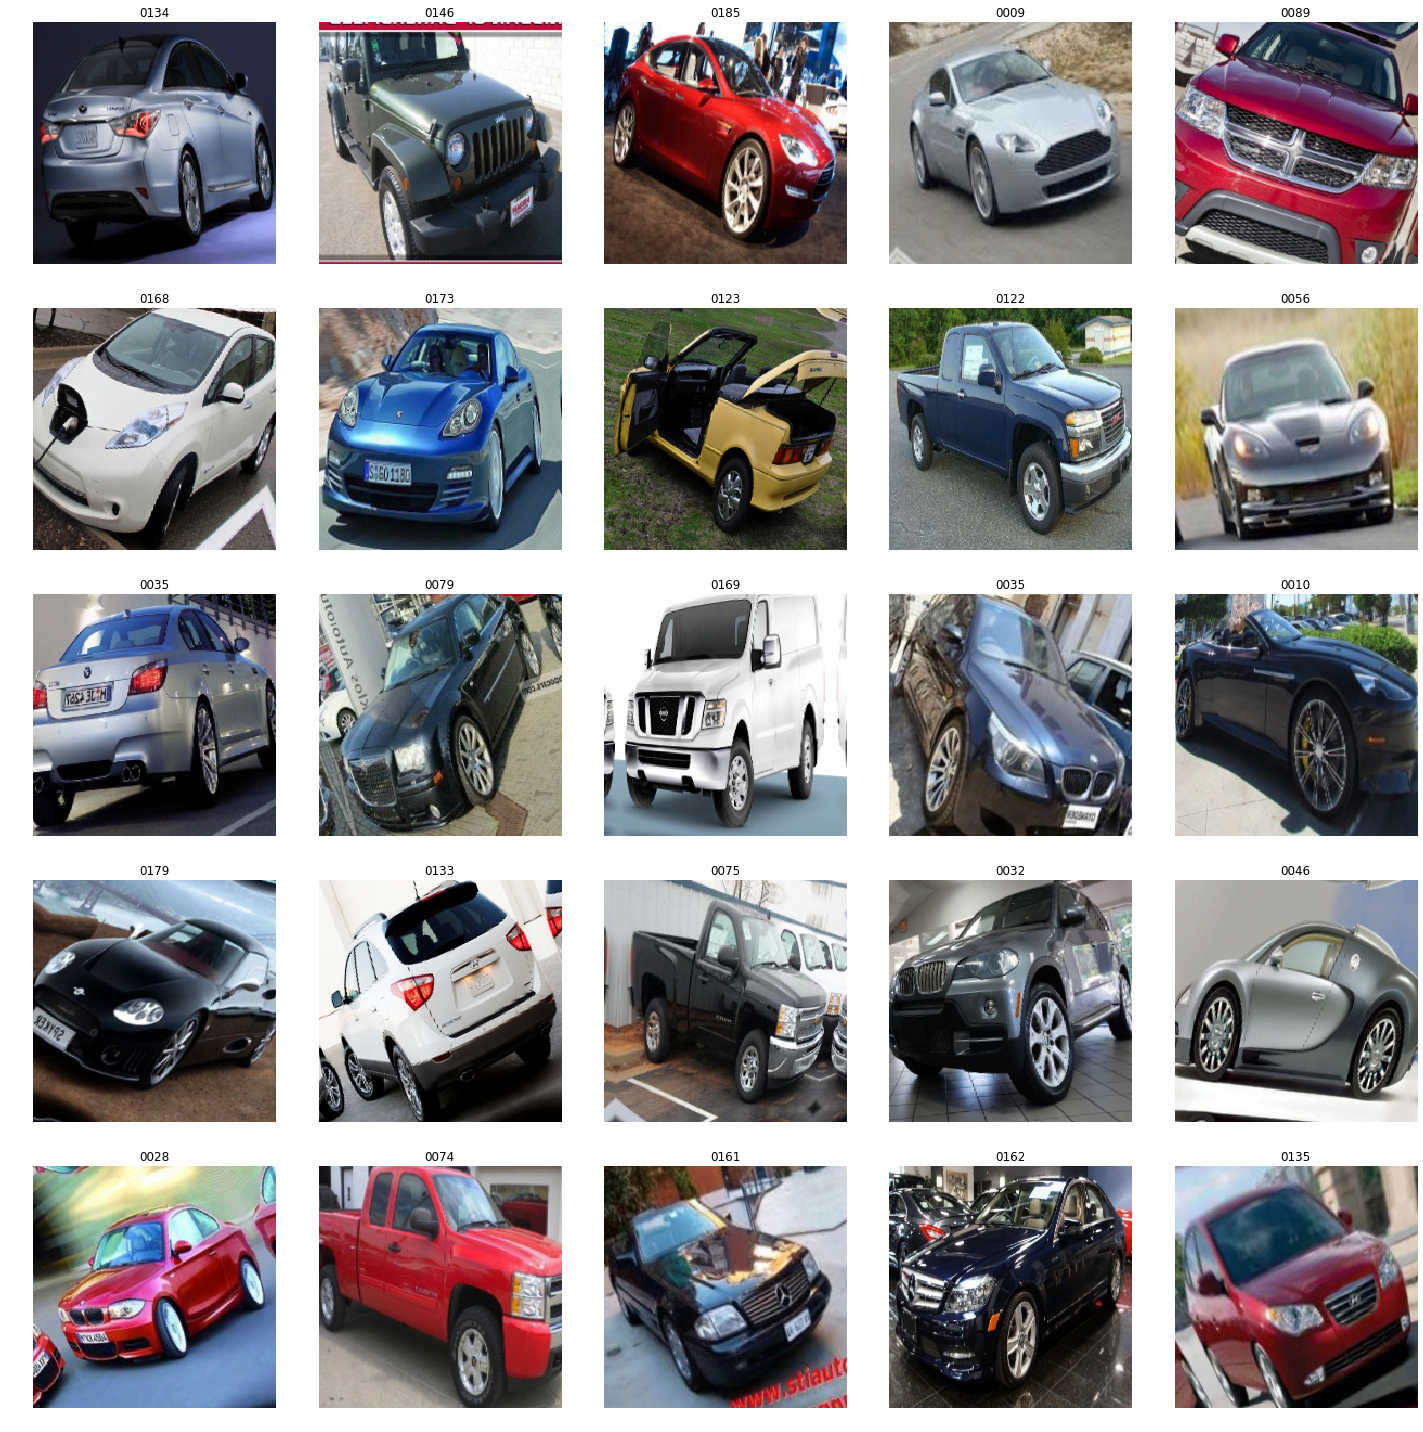

In [5]:
data.show_batch()

In [6]:
len(data.classes), data.c

(196, 196)

In [7]:
learn = cnn_learner(data, models.resnet152, metrics=[accuracy,error_rate])

In [8]:
learn.fit_one_cycle(10)

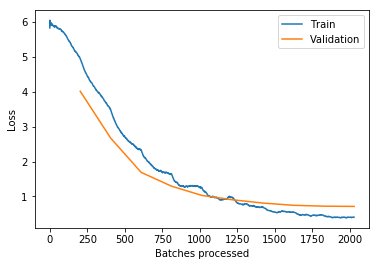

In [9]:
# We see that only after 6 epochs, training loss starts to get lesser than validation loss. 
learn.recorder.plot_losses()

In [8]:
# Interpretation will help in analysing top losses
def get_interp(learn):
    interp = ClassificationInterpretation.from_learner(learn)
    losses,idxs = interp.top_losses()
    len(data.valid_ds)==len(losses)==len(idxs)
    return interp

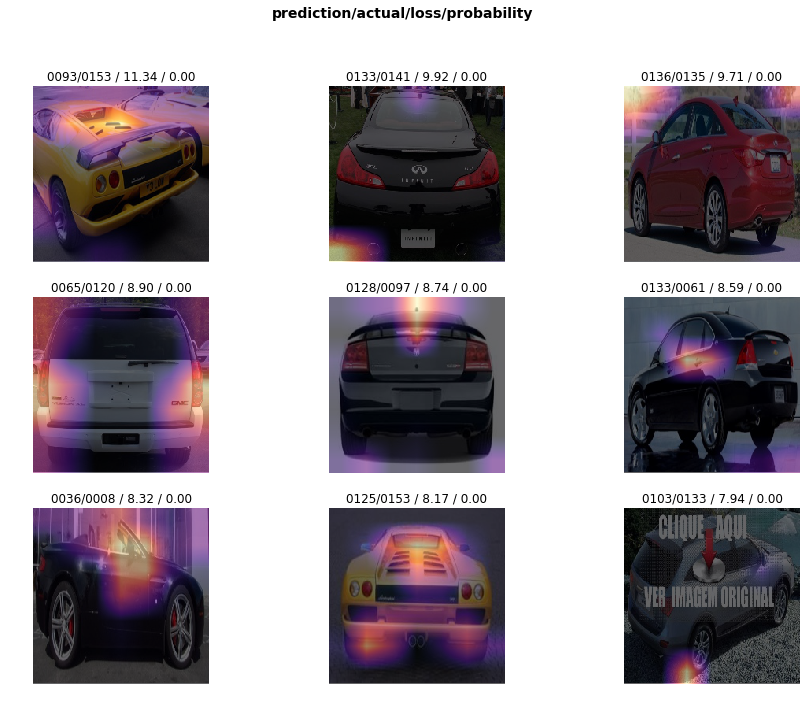

In [11]:
#Let's look at the top losses.
interp = get_interp(learn)
interp.plot_top_losses(9, figsize=(15,11))

In [12]:
# grab out of the confusion matrix the particular combinations of predicted and actual that got wrong the most often.
interp.most_confused(min_val=3) # combinations that got confused 3 times or more.

[('0042', '0043', 6),
 ('0019', '0014', 5),
 ('0125', '0124', 5),
 ('0084', '0083', 4),
 ('0017', '0016', 3),
 ('0025', '0014', 3),
 ('0040', '0041', 3),
 ('0045', '0046', 3),
 ('0071', '0064', 3),
 ('0074', '0054', 3),
 ('0074', '0075', 3)]

In [9]:
# From the above, we see that the majority confusion is between different models of the same make.
# Let's calculate accuracy
def get_acc(learn):
    preds,y, loss = learn.get_preds(with_loss=True)
    acc = accuracy(preds, y)
    print('The accuracy is {0}.'.format(acc))

In [14]:
get_acc(learn)

The accuracy is 0.7986494898796082.


In [15]:
# After 1st stage we got an accuracy of 79.86% and it is working good enough for identifying cars of different makes.
# So, let's save it.
learn.save('rn152_train_stage1')

## Stage 2

In [10]:
# From the training and validation losses plot, we found that only after 6 epochs training loss starts to get lesser 
# than validation loss. And, it had not plateaued. So, we want to train the model more and fine tune its parameters
# to improve the accuracy. Let's load the initially trained model. 
learn.load('rn152_train_stage1')

Learner(data=ImageDataBunch;

Train: LabelList (6515 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0116,0116,0116,0116,0116
Path: data;

Valid: LabelList (1629 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0116,0116,0116,0116,0116
Path: data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64,

In [11]:
get_acc(learn)

The accuracy is 0.7986494898796082.


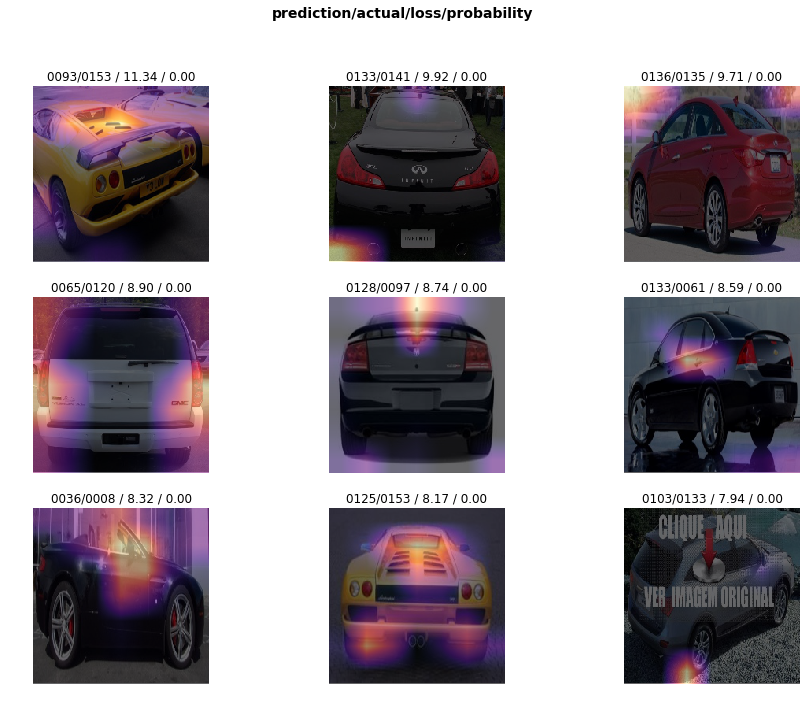

In [12]:
interp = get_interp(learn)
interp.plot_top_losses(9, figsize=(15,11))

In [13]:
# grab out of the confusion matrix the particular combinations of predicted and actual that got wrong the most often.
interp.most_confused(min_val=3) # combinations that got confused 3 times or more.

[('0042', '0043', 6),
 ('0019', '0014', 5),
 ('0125', '0124', 5),
 ('0084', '0083', 4),
 ('0017', '0016', 3),
 ('0025', '0014', 3),
 ('0040', '0041', 3),
 ('0045', '0046', 3),
 ('0071', '0064', 3),
 ('0074', '0054', 3),
 ('0074', '0075', 3)]

In [12]:
import gc; gc.collect()

0

In [13]:
# Let's try to find out the learning rate from which things really started getting worse (or loss kept increasing).
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


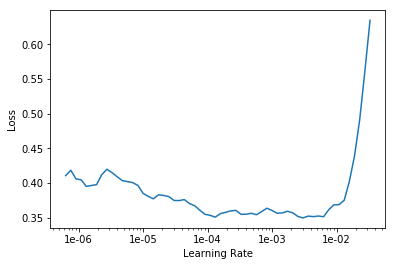

In [20]:
learn.recorder.plot()

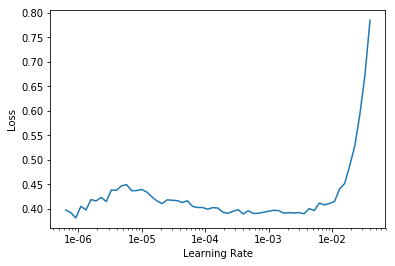

In [14]:
learn.recorder.plot()

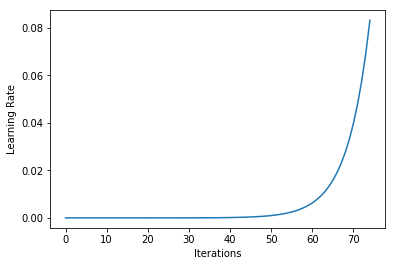

In [21]:
# Above plot shows us that loss kept increasing after the learning rate >= 1e-02.
# Below plot shows that learning rate starts increasing after some 50 iterations.
learn.recorder.plot_lr()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


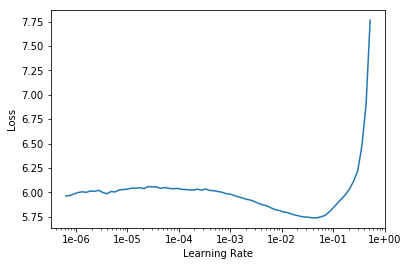

In [22]:
# Let's look at the learning rate vs loss plot of resnet101 learner trained on standard imagenet dataset.
learner = cnn_learner(data, models.resnet152, metrics=error_rate)
learner.lr_find()
learner.recorder.plot()

In [15]:
# From the above plot, we find that loss is decreasing in the learning rate range = [1e-4, 1e-2]
# So, let's unfreeze our model to the tip of head and train for another 40 epochs with a learning rate which is well 
# the point from when things started getting worse. 
learn.unfreeze()
learn.fit_one_cycle(40, max_lr=slice(1e-5,1e-3))

In [16]:
learn.save('rn152_train_stage2')

In [18]:
# Let's export this model and run on test data
learn.export('/home/jupyter/ai-for-sea/data/export-rn152_train_stage2-50e.pkl')

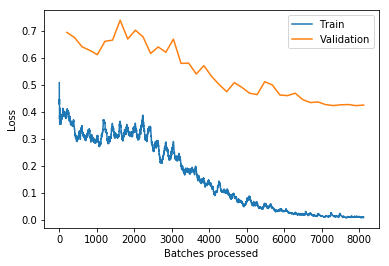

In [17]:
learn.recorder.plot_losses()

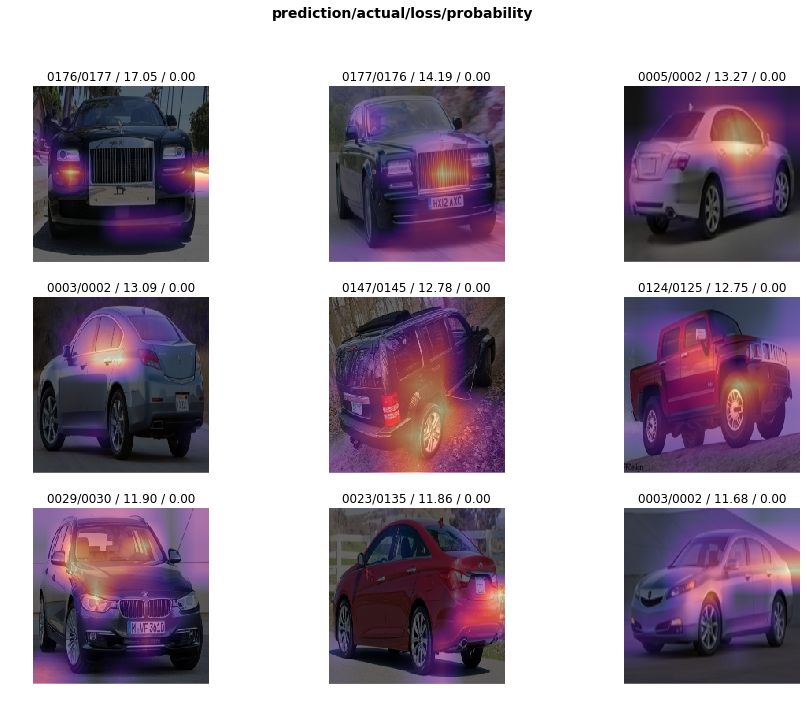

In [19]:
#Let's look at the top losses.
interp = get_interp(learn)
interp.plot_top_losses(9, figsize=(15,11))

In [20]:
interp.most_confused(min_val=3)

[('0019', '0014', 4),
 ('0042', '0043', 4),
 ('0031', '0036', 3),
 ('0125', '0124', 3),
 ('0176', '0177', 3)]

In [21]:
get_acc(learn)

The accuracy is 0.9171270728111267.


In [22]:
import gc; gc.collect()

24570